# Dynamical Modeling

Here, we use the generalized dynamical model to solve the full transcriptional dynamics. 

That yields several additional insights such as latent time and identification of putative driver genes.

As in the previous tutorial, it is illustratively applied to endocrine development in the [pancreas](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html).

In [1]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.0 (python 3.8.2) on 2020-05-15 00:27.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization


### Prepare the Data
Processing consists of gene selection, normalizing by total size, logarithmizing X, and computing moments for velocity estimation. See the previous tutorial for further explanation.

In [3]:
adata = scv.datasets.pancreas()

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 20801 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


### Dynamical Model

We run the dynamical model to learn the full transcriptional dynamics of splicing kinetics. 

It is solved in a likelihood-based expectation-maximization framework, by iteratively estimating the
parameters of reaction rates and latent cell-specific variables, i.e. transcriptional state and cell-internal latent time. It thereby aims to learn the unspliced/spliced phase trajectory for each gene.

In [5]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:13:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [6]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Running the dynamical model can take a while. Hence, you may want to store the results for re-use, with `adata.write('data/pancreas.h5ad'`, which can later be read with `adata = scv.read('data/pancreas.h5ad')`.

In [7]:
#adata.write('data/pancreas.h5ad', compression='gzip')
#adata = scv.read('data/pancreas.h5ad')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


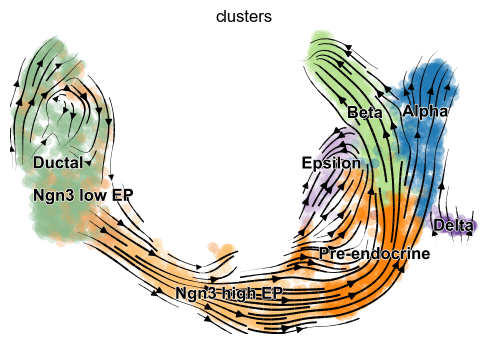

In [8]:
scv.pl.velocity_embedding_stream(adata, basis='umap')


### Kinetic rate paramters

The rates of RNA transcription, splicing and degradation are estimated without the need of any experimental data.

They can be useful to better understand the cell identity and phenotypic heterogeneity.

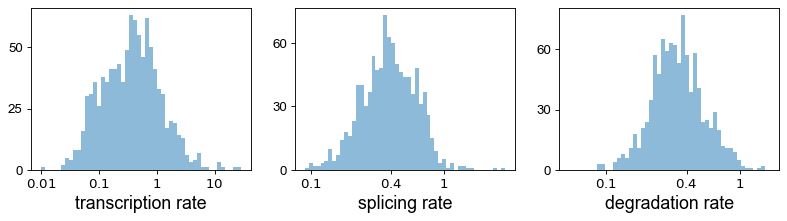

,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
index,,,,,,,,,,,,,,,,
Sntg1,0.401981,0.015726,0.005592,0.088792,23.404254,42.849447,1.029644,0.030838,0.406523,0.0,0.0,0.159472,2.470675,0.094304,0.149138,5.355590
Sbspon,0.624803,0.464865,2.437113,0.379645,3.785993,0.154771,0.058587,0.178859,0.252135,0.0,0.0,0.182088,0.164805,0.430623,0.674312,1.193015
Mcm3,0.292389,3.096367,39.995796,0.638543,2.049463,0.013943,0.016253,0.673142,0.228207,0.0,0.0,0.467683,0.051432,1.927742,0.687468,0.887607
Fam135a,0.384662,0.172335,0.118088,0.204538,11.239574,1.124040,0.356525,0.149868,0.283343,0.0,0.0,0.387921,1.345830,0.393197,0.671096,3.390194
Adgrb3,0.384552,0.046828,0.006750,0.196856,6.992542,71.850736,2.153206,0.030417,0.250195,0.0,0.0,0.068851,5.214500,0.093570,0.556878,1.893389


In [9]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)    
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)
    
scv.get_df(adata, 'fit*', dropna=True).head()


The estimated gene-specific parameters comprise rates of transription (`fit_alpha`), splicing (`fit_beta`), degradation (`fit_gamma`), switching time point (`fit_t_`), a scaling parameter to adjust for under-represented unspliced reads (`fit_scaling`), standard deviation of unspliced and spliced reads (`fit_std_u`, `fit_std_s`), the gene likelihood (`fit_likelihood`), inferred steady-state levels (`fit_steady_u`, `fit_steady_s`) with their corresponding p-values (`fit_pval_steady_u`, `fit_pval_steady_s`), the overall model variance (`fit_variance`), and a scaling factor to align the gene-wise latent times to a universal, gene-shared latent time (`fit_alignment_scaling`).

### Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics. 

computing terminal states
    identified 2 regions of root cells and 1 region of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


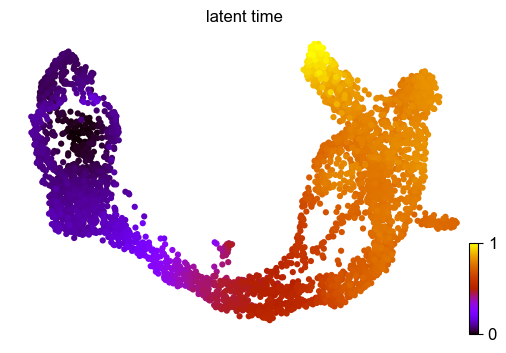

In [10]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)


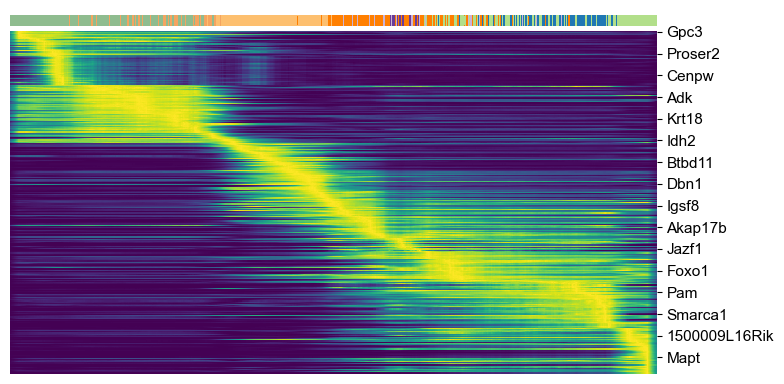

In [11]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)


### Top-likelihood genes

Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model. 

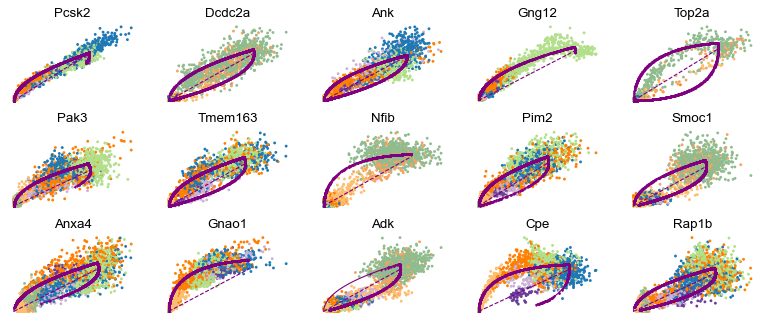

In [12]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)


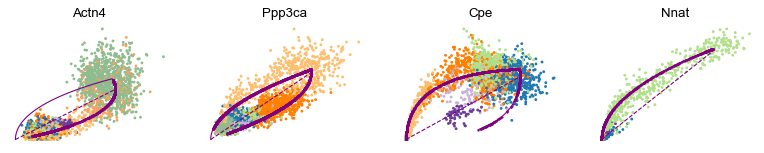

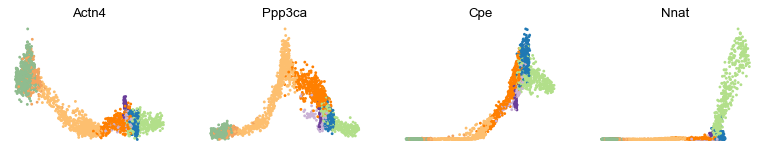

In [13]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)


### Cluster-specific top-likelihood genes

Moreover, partial gene likelihoods can be computed for a each cluster of cells to enable cluster-specific identification of potential drivers.

In [14]:
scv.tl.rank_dynamical_genes(adata, groupby='clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:03) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
0,Dcdc2a,Dcdc2a,Rbfox3,Abcc8,Pcsk2,Cpe,Pcsk2,Tox3
1,Top2a,Adk,Mapre3,Tmem163,Ank,Gnao1,Rap1b,Rnf130
2,Nfib,Mki67,Btbd17,Gnao1,Tmem163,Pak3,Pak3,Meis2
3,Wfdc15b,Rap1gap2,Sulf2,Ank,Tspan7,Pim2,Abcc8,Adk
4,Cdk1,Top2a,Tcp11,Tspan7,Map1b,Map1b,Klhl32,Rap1gap2


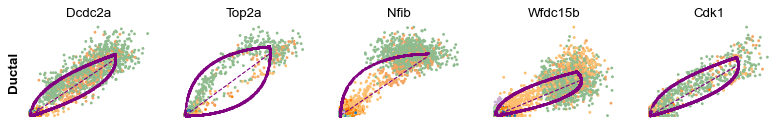

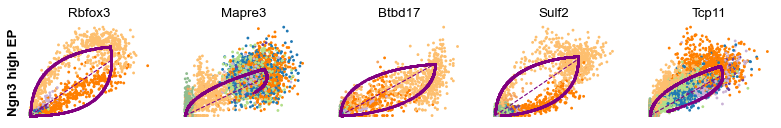

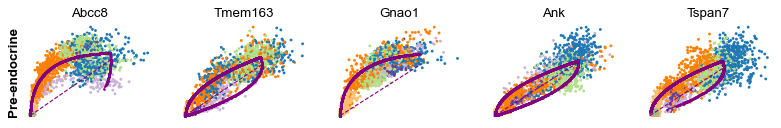

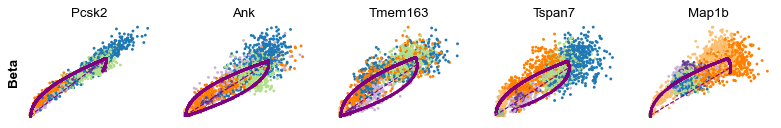

In [15]:
for cluster in ['Ductal', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=cluster, frameon=False)
